# Ch.3 Classification (Part I)

## Dataset for image classification (MNIST)
 * MNIST는 7만개의 숫자 이미지로 구성된 데이터
 * Classification 성능을 평가할 때 일종의 벤치마크 같은 용도로 종종 사용되기도 함
 * Scikit-learn은 이 MNIST Dataset을 내장하고 있음

In [1]:
from sklearn.datasets import load_digits
 
mnist = load_digits()
X = mnist["data"]
y = mnist["target"]
 
 
print(X.shape)

(1797, 64)


4


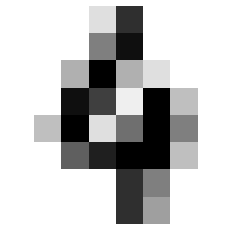

In [2]:
import matplotlib
import matplotlib.pyplot as plt
 
sample = X[100]
smpl_image = sample.reshape(8,8)
print(y[100])
plt.imshow(smpl_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
for train_indices, test_indices in sss.split(X,y):
  train_x, test_x = X[train_indices], X[test_indices]
  train_y, test_y = y[train_indices], y[test_indices]
 
print(train_x.shape)
print(train_y.shape)

(1437, 64)
(1437,)


## Training Binary Classifier
 - 입력에 대하여 특정 숫자인지 아닌지 (True or False)를 출력하는 Classifier
 - SGD (Stochastic Gradient Decsent) Classifier 
   - 큰 규모의 입력 데이터에 대하여 효율적 (트레이닝을 독립적으로 수행하기 때문에??)
   

In [ ]:
from sklearn.linear_model import SGDClassifier

train_y_4 = (train_y == 4)
print(train_y_4)

sgd_clf = SGDClassifier(random_state=43)
sgd_clf.fit(train_x, train_y_4)

[False False False ...  True False False]


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=43, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([sample])


array([ True])

## Performance Measures

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sfolds = StratifiedKFold(n_splits=3, random_state=43, shuffle=True)

for train_index, test_index in sfolds.split(train_x, train_y_4):
  cloned_clf = clone(sgd_clf)
  x_train_folds = train_x[train_index]
  y_train_folds = train_y_4[train_index]
  x_test_fold = train_x[test_index]
  y_test_fold = train_y_4[test_index]

  cloned_clf.fit(x_train_folds, y_train_folds)
  y_pred = cloned_clf.predict(x_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


0.9958246346555324
0.9832985386221295
0.9979123173277662


> random split한 data를 cross valdiation 테스트 한 결과 98% 이상의 정확도를 갖는 것 처럼 보일 수 있지만 이는 전체 데이터 중 해당 모델이 학습된 샘플(여기에서는 4)의 비율이 높다는 사실에 의해 편향될 수 있다. 이를 확인하기 위해 모두 true를 반환하는 classifier를 비교해보자

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np

class DumbClassifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
from sklearn.model_selection import cross_val_score

dumb_clf = DumbClassifier()
cross_val_score(dumb_clf, train_x, train_y_4, cv=3, scoring="accuracy")

array([0.9039666 , 0.91440501, 0.87891441])

> 위 예시와 같이 classification에서는 (특히 데이터에 특정 Class에 skew가 있는 경우) 단순한 accuracy가 model의 적절한 performance measure 수단으로 사용되기 어렵다.



## cross_val_predict와 confusion matrix
 - cross_val_predict는 기본적인 동작은 cross_val_score와 동일하나 score 대신 각각의 fold의 prediction을 merge하여 original set과 동일한 size의 prediction을 반환한다.
 - 이를 원래의 label과 비교하여 false-false / false-true / true-false / true-true의 2x2 matrix를 얻기위하여 confusion matrix를 사용

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, train_x, train_y_4, cv=3)
y_train_pred

array([False, False, False, ...,  True, False, False])

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_y_4, y_train_pred)

array([[1285,    7],
       [   4,  141]])

>  Confusion Matrix는 다음과 같은 형태를 갖는 2x2 matrix

| |Classified Negative | Classified Positive|
|---|:---:|:---:|
| Negative | True Negative      |   False Positive       |
| Positive | False Negative     |    True Positive      |

## Classifier Precision & Recall
> Confusion Matrix는 전체 positive 중 false positive와 true positve를 구분함으로써 data 내에 특정 class의 skew로 인한 착시 효과를 제거할 수 있다. 이를 조금 더 명료한 형태로 나타내는 것이 classifier의 precesion과 recall이다.

#### precision = True_Positive / (True_Positive + False_Positive) 
> classifier가 대부분의 입력에 대해 negative로 prediction을 하는 경우 (필터에 비유하면 filter가 좁아지게 되는 경우) 수 많은 false negative에도 소수의 true positve가 존재하게 되면 높은 precision을 보이게된다. 이를 보완하기 위해 recall을 동시에 참조한다. (recall은 precesion과 반대의 문제점을 가지고 있다.)

#### recall = True_Positive / (True_Positive + False_Negative)



In [ ]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(train_y_4, y_train_pred))
print(recall_score(train_y_4, y_train_pred))

0.9527027027027027
0.9724137931034482


## Combine precision & recall into single metric (f1 score)

In [ ]:
from sklearn.metrics import f1_score

f1_score(train_y_4, y_train_pred)

0.9624573378839592

## Precision/Recall Tradeoff
* high precesion -> Too many false negative 
* high recall -> Too many false positive 
* Classifier의 목적에 따라서 precesion과 recall의 중요도가 달라질 수 있음. 
  - 아동용 비디오 컨텐츠 필터 (하나의 false positive라도 있으면 문제가 생길 수 있는 경우) -> **precision이 중요**
  - Surveilance Camera (하나의 false negatvie라도 있으면 문제가 될 수 있는 경우) -> **recall이 중요**

* Binary Classifier의 내부를 크게 2가지 요소로 쪼개서 보면
> Binary classifier = decision_function (positive일 확률 혹은 점수) + threshold (positive로 판정하는 기준 확률)

 - 여기서 threshold를 높인다는 것은 precision을 높이는 것
 - 반대로 threshold를 낮춘다는 것은 recall을 높이는 것

 - scikit-learn에서는 predict method외에 decision_function method을 통해 입력의 positive / negatve scale을 얻을 수 있고 
 - 이를 통해 threshold에 따른 recall / precision의 변화를 살펴 볼 수 있음 (단, classifier 내부의 실제 값을 바꾸는 것은 허용되지 않음) 
 

In [ ]:
y_scores = cross_val_predict(sgd_clf, train_x, train_y_4, cv=3, method="decision_function")
y_scores

array([-4377.21929884, -2416.43498511, -2618.91597751, ...,
        3179.50079983, -5972.36497974, -4505.77545125])

## Draw precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve

sgd_scores = sgd_clf.decision_function(train_x)


precisions , recalls, thresholds = precision_recall_curve(train_y_4, y_scores)



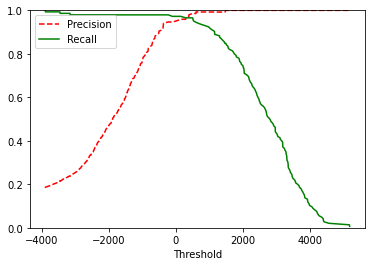

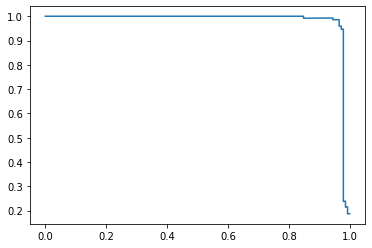

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.plot(recalls, precisions)
plt.show()

## ROC(**R**eceiver **O**perating **C**haracteristic) Curve 
 - True Positive rate vs False Positive rate 
  - False positive & True Positive increases -> recall increases / precesion decreases
  -  False positive & True Positive decreases -> recall decreases / precesion increases


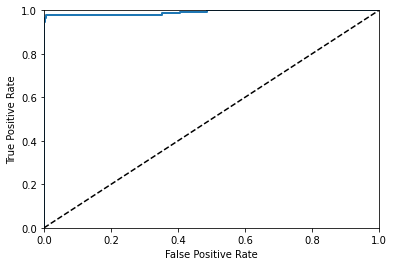

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(train_y_4, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  
plot_roc_curve(fpr, tpr)
plt.show()

## Compare Binary Classifier model (ROC AUC) 
- ROC Curve의 면적을 지표로써 서로 다른 classifier model의 성능을 비교 (클수록 좋음)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_y_4, y_scores)


0.9912245115832176

## ROC Curve VS PR (Precision Recall) Curve 
 - false positive가 더 문제가될 경우 / positive class가 드문 application -> PR Cruve 
 - 그렇지 않은 경우 ROC Curve를 사용

### *일반적으로 ROC Curve / 그렇지 않고 false positive에 조금 더 주의를 기울일 필요가 있다면 PR Curve*

## Random Forest Classifier

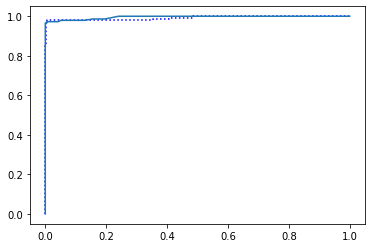

0.9912245115832176
0.9956549588982598


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=45)
rf_probas_y = cross_val_predict(rf_clf, train_x, train_y_4, cv=3, method="predict_proba") 
# the returned vector is (N x 2) predict_proba 
# 1st column is negative probability 
# 2nd colimn is positive probability 

rf_scores_y = rf_probas_y[:,1] #  convert proba to scores by simply selecting 2nd column
rf_fpr, rf_tpr, rf_threshold = roc_curve(train_y_4, rf_scores_y)

plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(rf_fpr, rf_tpr, label="Random Forest")
plt.show()

print(roc_auc_score(train_y_4, y_scores))
print(roc_auc_score(train_y_4, rf_scores_y))
